# Загрузка Order book из CSV

In [3]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

### Скоростная загрузка с диска, из заархивированного CSV-файла

In [4]:
# результат выполнения запроса:
# select * from tvf_get_order_book_snapshots(2880) where exchange='binance' and pair='ETH/USDT' # запрос на 20 минут
#order = pd.read_csv('tvf_get_order_book_snapshots 15.09.2018-01.10.2018.zip', index_col='dt')

In [5]:
# загрузка истории
# 15 секунд
db = Database()
sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-09-23'"
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)

In [6]:
df_history.shape

(2562574, 11)

In [7]:
df_history.sort_values('dt').tail()

,rownum,id_ex_pair,exchange,pair,price,amount,type,side,id,location,insert_date
dt,,,,,,,,,,,
2018-10-17 16:04:09,11666998.0,19,binance,ETH/USDT,212.619995,14.95472,None,sell,39518977.0,memory,2018-10-17 16:04:10.6366667
2018-10-17 16:04:11,11667002.0,19,binance,ETH/USDT,212.679993,0.27487,None,buy,39518980.0,memory,2018-10-17 16:04:13.3900000
2018-10-17 16:04:11,11667001.0,19,binance,ETH/USDT,212.679993,0.00004,None,buy,39518981.0,memory,2018-10-17 16:04:13.3900000
2018-10-17 16:04:11,11667000.0,19,binance,ETH/USDT,212.660004,4.52470,None,buy,39518978.0,memory,2018-10-17 16:04:13.3900000
2018-10-17 16:04:11,11666999.0,19,binance,ETH/USDT,212.619995,11.13213,None,sell,39518979.0,memory,2018-10-17 16:04:13.3900000


In [15]:
#перевод в нужные интервалы
interval = 60 # minutes

#df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()
hist = df_history[['price', 'amount']].resample(str(interval)+'min').mean()
hist.shape

(593, 2)

In [16]:
hist.fillna(method='ffill', inplace=True)

In [17]:
hist.head()

,price,amount
dt,,
2018-09-23 00:00:00,240.195733,2.781084
2018-09-23 01:00:00,239.586590,3.137120
2018-09-23 02:00:00,240.185218,3.280276
2018-09-23 03:00:00,240.515473,2.404552
2018-09-23 04:00:00,238.519611,4.545146


In [18]:
plt.rcParams['figure.figsize'] = [14, 7]

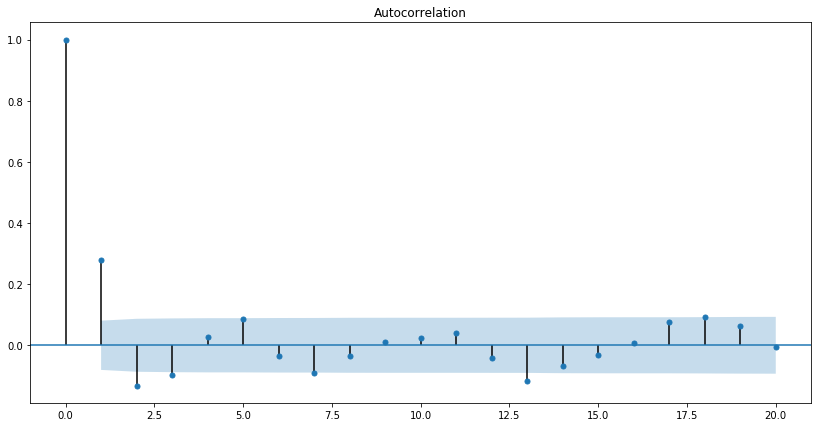

In [19]:
_ = plot_acf(hist[0:len(hist)].price.diff().dropna(), lags=20, alpha=0.05)

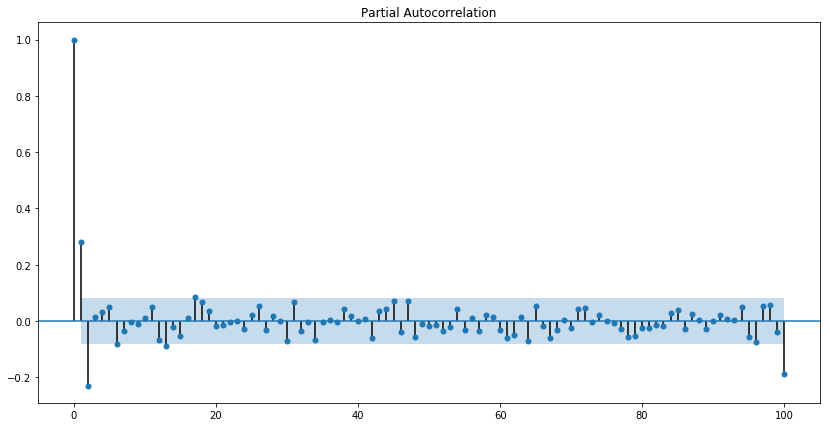

In [20]:
_ = plot_pacf(hist[0:len(hist)].price.diff().dropna(), lags=100, alpha=0.05)

In [45]:
#test-train split

split_point = int(len(hist)*.9)
train, test = hist[0:split_point], hist[split_point:len(hist)]
len(hist), len(train), len(test)

(593, 533, 60)

In [46]:
model = ARIMA(train.price, order=(1,1,0))

In [47]:
model_fit = model.fit()

In [48]:
plt.rcParams['figure.figsize'] = [16, 9]

<Figure size 1152x648 with 0 Axes>

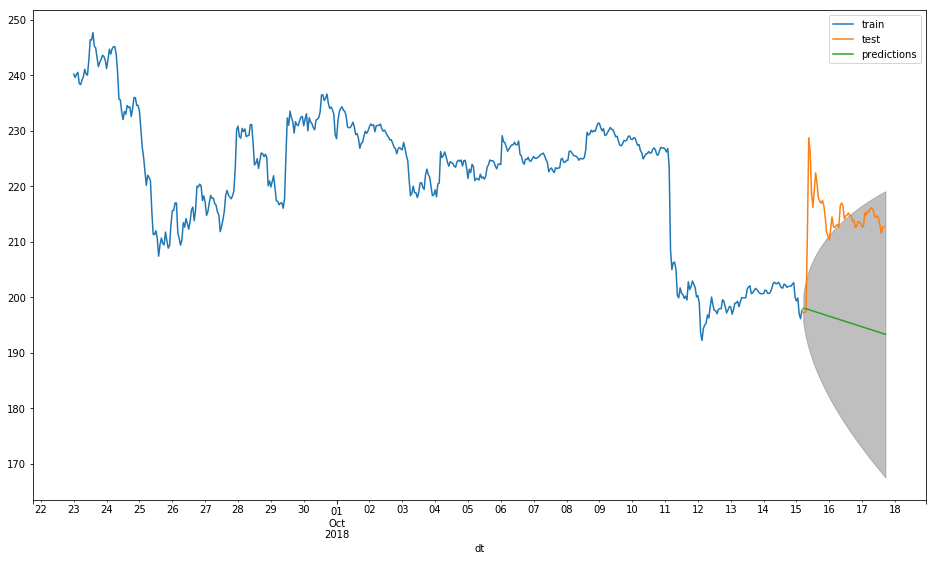

In [49]:
plt.figure()
fig, ax = plt.subplots()

train.price.plot()
test.price.plot(ax=ax)
model_fit.plot_predict(start=len(train), end=len(hist), alpha=0.1, ax=ax)

ax.legend(['train', 'test', 'predictions'])
plt.show()

In [26]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                  443
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -839.037
Method:                       css-mle   S.D. of innovations              1.608
Date:                Wed, 17 Oct 2018   AIC                           1686.075
Time:                        18:44:18   BIC                           1702.449
Sample:                    09-23-2018   HQIC                          1692.533
                         - 10-11-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0863      0.092     -0.941      0.347      -0.266       0.094
ar.L1.D.price     0.2741      0.047      5.796      0.000       0.181       0.367
ar.L2.D.price    -0.1062      0.047     

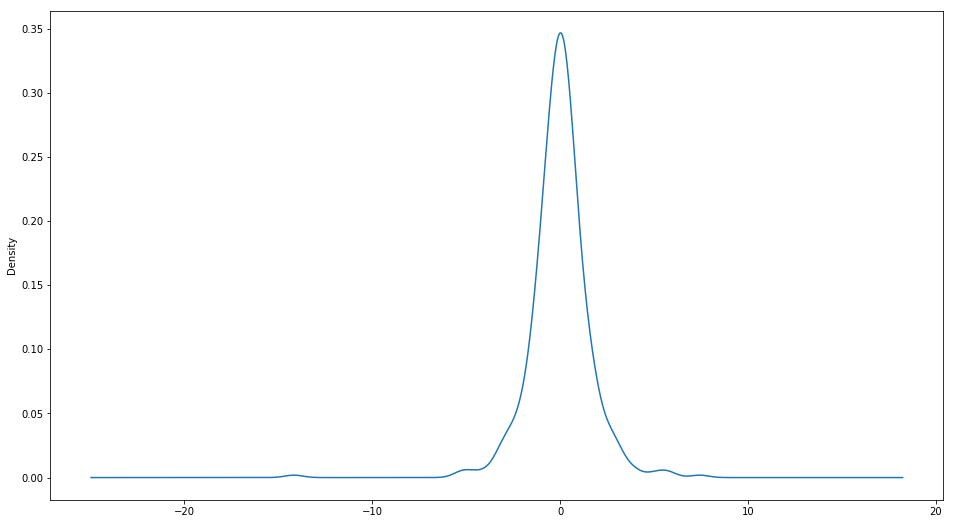

In [31]:
model_fit.resid.plot(kind='kde')

In [34]:
model_fit.resid.describe()

count    443.000000
mean       0.000292
std        1.618971
min      -14.159312
25%       -0.701026
50%        0.010400
75%        0.680665
max        7.436209
dtype: float64